In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, glob
import numpy as np
from tqdm import tqdm
import torch
import smplx
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.transform import Rotation as R
from scipy.ndimage import gaussian_filter1d
import json
import csv
import pdb
import pickle

In [2]:
# need same format as in utils_canonicalize_amass.py??

In [9]:
def get_body_model(type, gender, batch_size,device='cpu'):
    '''
    type: smpl, smplx smplh and others. Refer to smplx tutorial
    gender: male, female, neutral
    batch_size: an positive integar
    '''
    body_model_path = '/home/yuxinyao/body_models/'
    body_model = smplx.create(body_model_path, model_type=type,
                                    gender=gender, ext='npz',
                                    num_pca_comps=12,
                                    create_global_orient=True,
                                    create_body_pose=True,
                                    create_betas=True,
                                    create_left_hand_pose=True,
                                    create_right_hand_pose=True,
                                    create_expression=True,
                                    create_jaw_pose=True,
                                    create_leye_pose=True,
                                    create_reye_pose=True,
                                    create_transl=True,
                                    batch_size=batch_size
                                    )
    if device == 'cuda':
        return body_model.cuda()
    else:
        return body_model
        

In [282]:
with open('/home/yuxinyao/datasets/egobody/smplx_camera_wearer/recording_20210907_S02_S01_01/body_idx_1/results/frame_01551/000.pkl', 'rb') as f:
    data = dict(pickle.load(f))

In [283]:
bm_one_female =get_body_model('smplx','female',1,device='cuda')

In [284]:
transl = data['transl']
pose = data['body_pose']
global_orient = data['global_orient']
betas = data['betas']

In [285]:
global_orient

array([[ 0.9270807 ,  0.37623283, -3.0154164 ]], dtype=float32)

In [58]:
# bodyconfig = {}
# bodyconfig['transl'] = torch.FloatTensor(transl).cuda()
# bodyconfig['global_orient'] = torch.FloatTensor(global_orient).cuda()
# bodyconfig['body_pose'] = torch.FloatTensor(pose).cuda()
# bodyconfig['betas'] = torch.FloatTensor(betas).cuda()
# smplxout = bm_one_female(**bodyconfig)
# joints = smplxout.joints.squeeze().detach().cpu().numpy()
# x_axis = joints[2,:] - joints[1,:]
# x_axis[-1] = 0
# x_axis = x_axis / np.linalg.norm(x_axis)
# z_axis = np.array([0,0,1])
# y_axis = np.cross(z_axis, x_axis)
# y_axis = y_axis/np.linalg.norm(y_axis)
# global_ori_new = np.stack([x_axis, y_axis, z_axis], axis=1)
# transl_new = joints[:1,:] 

# return global_ori_new, transl_new

In [253]:
# get new coordinate

# bodyconfig = {}
# bodyconfig['transl'] = torch.FloatTensor(transl).cuda()
# bodyconfig['global_orient'] = torch.FloatTensor(global_orient).cuda()
# bodyconfig['body_pose'] = torch.FloatTensor(pose).cuda()
# bodyconfig['betas'] = torch.FloatTensor(betas).cuda()

# smplxout = bm_one_female(**bodyconfig)
# joints = smplxout.joints.squeeze().detach().cpu().numpy()
# x_axis = joints[2,:] - joints[1,:]
# x_axis[-1] = 0
# x_axis = x_axis / np.linalg.norm(x_axis)
# z_axis = np.array([0,0,1])
# y_axis = np.cross(z_axis, x_axis)
# y_axis = y_axis/np.linalg.norm(y_axis)
# global_ori_new = np.stack([x_axis, y_axis, z_axis], axis=1)
# transl_new = joints[:1,:] # put the local origin to pelvis


# transf_rotmat = global_ori_new
# transf_transl = transl_new



In [254]:
# #calibrate offset
# # n_batches = 1
# # bodyconfig = {}
# # bodyconfig['body_pose'] = torch.FloatTensor(pose[:,3:]).cuda()
# # bodyconfig['betas'] = torch.FloatTensor(betas).unsqueeze(0).repeat(n_batches,1).cuda()
# # bodyconfig['transl'] = torch.zeros([n_batches,3], dtype=torch.float32).cuda()
# # bodyconfig['global_orient'] = torch.zeros([n_batches,3], dtype=torch.float32).cuda()
# smplx_out = bm_one_female(return_verts=True, **bodyconfig)
# delta_T = smplx_out.joints[:,0,:] # we output all pelvis locations
# delta_T = delta_T.detach().cpu().numpy() #[t, 3]


In [286]:
global_ori = R.from_rotvec(global_orient).as_matrix()


In [287]:
global_ori.shape

(1, 3, 3)

In [288]:
global_ori_new = np.einsum('ij,tjk->tik', R.from_rotvec([np.pi/2, 0, np.pi]).as_matrix() , global_ori)

In [289]:
global_ori_new.shape

(1, 3, 3)

In [290]:
temp_bodyconfig = {}
temp_bodyconfig['transl'] = torch.FloatTensor(transl).cuda()
temp_bodyconfig['global_orient'] = torch.FloatTensor(R.from_matrix(global_ori_new).as_rotvec()).cuda()
temp_bodyconfig['body_pose'] = torch.FloatTensor(pose).cuda()
temp_bodyconfig['betas'] = torch.FloatTensor(betas).cuda()

smplxout = bm_one_female(**temp_bodyconfig)
joints = smplxout.joints.squeeze().detach().cpu().numpy()
x_axis = joints[2,:] - joints[1,:]
x_axis[-1] = 0
x_axis = x_axis / np.linalg.norm(x_axis)
z_axis = np.array([0,0,1])
y_axis = np.cross(z_axis, x_axis)
y_axis = y_axis/np.linalg.norm(y_axis)
global_ori_new = np.stack([x_axis, y_axis, z_axis], axis=1)
transl_new = joints[:1,:] # put the local origin to pelvis


transf_rotmat = global_ori_new
transf_transl = transl_new

In [291]:
smplx_out = bm_one_female(return_verts=True, **temp_bodyconfig)
delta_T = smplx_out.joints[:,0,:] # we output all pelvis locations
delta_T = delta_T.detach().cpu().numpy() #[t, 3]

In [292]:
transf_rotmat.shape

(3, 3)

In [293]:
# R.from_matrix(global_ori_new).as_matrix().shape
type(global_ori)
global_ori.shape

(1, 3, 3)

In [294]:
global_ori_new2 =  np.expand_dims(global_ori_new,0)

In [313]:
# b = np.dstack([global_ori_new2]*10)

In [315]:
# b

In [295]:
global_ori_new2

array([[[-0.34426281,  0.93887332,  0.        ],
        [-0.93887329, -0.34426282,  0.        ],
        [ 0.        ,  0.        ,  1.        ]]])

In [296]:
global_ori_new = np.einsum('ij,tjk->tik', transf_rotmat.T, global_ori_new2)

In [297]:
global_ori_new

array([[[0.99999994, 0.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 0.        , 1.        ]]])

In [160]:
# global_ori_new = np.einsum('ij,tjk->tik', R.from_rotvec([np.pi, 0, 0]).as_matrix() , global_ori_new)


In [298]:
global_ori_new

array([[[0.99999994, 0.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 0.        , 1.        ]]])

In [299]:
# global_ori_new = np.einsum('ij,tjk->tik', R.from_rotvec([0, 0, np.pi]).as_matrix() , global_ori_new)

In [300]:
global_ori_new

array([[[0.99999994, 0.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 0.        , 1.        ]]])

In [301]:
global_orient_save = R.from_matrix(global_ori_new).as_rotvec()

In [302]:
global_orient_save#  why not 0 0 0 ?

array([[0., 0., 0.]])

In [303]:
transl2 = transl.repeat(10)

In [275]:
transl_save = np.einsum('ij,tj->ti', transf_rotmat.T, transl+delta_T-transf_transl)-delta_T

In [199]:
transl_save #why not 0,0,0??

array([[-0.00063879,  0.34957072, -0.01364826]])

In [276]:
data_out = data
data_out['trans'] = transl_save
data_out['body_pose'] = pose
data_out['betas'] = betas
data_out['gender'] = data['gender']
data_out['global_orient'] = global_orient_save



In [277]:
with open('/home/yuxinyao/datasets/egobody/test/canonicalized_xrotzrot4.pkl', 'wb') as f:
    pickle.dump(data_out,f)

In [281]:
print(global_orient_save)
print(data['global_orient'])

[[0. 0. 0.]]
[[0. 0. 0.]]


In [279]:
transl_save

array([[-0.87619786,  0.05534796, -0.01364851]])

In [170]:
global_ori

array([[[-0.82912547,  0.03542591, -0.55793904],
        [ 0.10275382, -0.97133237, -0.21437135],
        [-0.54953855, -0.23507111,  0.80171626]]])

In [171]:
smplxout = bm_one_female(**bodyconfig)

In [172]:
joints = smplxout.joints.squeeze(0)

In [173]:
jointNumpy = joints.detach().cpu().numpy()

In [174]:
j = joints[:24]

In [175]:
jnp = jointNumpy[:24]

In [176]:
#cal calibrate offset
bodyconfig = {}
bodyconfig['body_pose'] = torch.FloatTensor(pose).cuda()
bodyconfig['betas'] = torch.FloatTensor(betas).cuda()
bodyconfig['transl'] = torch.zeros([1,3], dtype=torch.float32).cuda()
bodyconfig['global_orient'] = torch.zeros([1,3], dtype=torch.float32).cuda()
smplx_out = bm_one_female(return_verts=True, **bodyconfig)
delta_T = smplx_out.joints[:,0,:] # we output all pelvis locations
delta_T = delta_T.detach().cpu().numpy() #[t, 3]
global_ori = R.from_rotvec(pose[:,:3]).as_matrix() # to [t,3,3] rotation mat
global_ori_new = np.einsum('ij,tjk->tik', transf_rotmat.T, global_ori)
pose[:,:3] = R.from_matrix(global_ori_new).as_rotvec()


# return delta_T


In [177]:
transf_rotmat, transf_transl = get_new_coordinate(bm_one_female, betas[:10], transl[:1,:], pose[:1,:66])

NameError: name 'get_new_coordinate' is not defined

Text(0.5, 0, 'Z ')

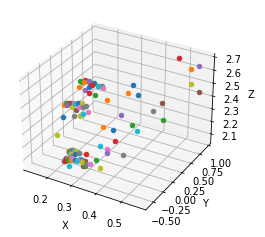

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i, j ,k in jointNumpy:
    ax.scatter(i, j, k, marker='o')
ax.set_xlabel('X ')
ax.set_ylabel('Y ')
ax.set_zlabel('Z ')
